# BERT Model (bert-base-german-cased from Huggingface) for Named Entity Recognition in German Legal Texts

Here I investigate a dataset containing German federal court decisions annotated with 19 different labels (source: https://github.com/elenanereiss/Legal-Entity-Recognition) and fine-tune 'bert-base-german-cased' from huggingface to recognize these labels. I shall compare the results with Leitner E., Rehm G., Moreno-Schneider J. (2019).


In [258]:
import csv
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns


import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from keras.preprocessing.sequence import pad_sequences

import transformers
from transformers import BertTokenizer, BertConfig
from transformers import get_linear_schedule_with_warmup
from transformers import BertForTokenClassification, AdamW
from transformers import AutoTokenizer
#from transformers import AutoConfig, TFAutoModelForTokenClassification
from transformers import get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from seqeval.metrics import f1_score, accuracy_score, precision_score, recall_score
from tqdm import tqdm, trange

## 1. Read data to dataframe

Create a csv-file and fill it with the data from the ConLL files.

In [425]:
# create an empty csv via a pandas dataframe and write lines from CoNLL files
df = pd.DataFrame(list())
df.to_csv('data.csv')

with open('data.csv', 'w') as data:
  data.write('running_text|word|tag\n')
  text = 0
  for item in os.listdir('./data/dataset_courts'):
    with open('./data/dataset_courts/'+item, 'r') as file:
      for line in file.readlines():
        if line == '\n':
          text += 1
        elif len(line.split())==2:
          word, tag = line.split()
        else:
          word, tag = [" ", line.strip()]
        data.write(f"{str(text)}|{word}|{tag}\n")

In [481]:
# create a dataframe and fill running_sentence column
data = pd.read_csv('data.csv', delimiter='|', quoting=3).fillna(method='ffill')
data.head(10)

,running_text,word,tag
0,0,(,O
1,0,Veräußerung,O
2,0,von,O
3,0,Anteilen,O
4,0,an,O
5,0,Kapitalgesellschaften,O
6,0,(,O
7,0,§,B-GS
8,0,17,I-GS
9,0,Abs.,I-GS


## 2. Quick investigation of data

### 2.1 Frequencies of different annotation labels

Word-labels at the beginning of an annorated expression in a sentence start with "B-...", the following words of the expression start with "I-...", unlabelled words are tagged as "O". Counting tags is done by counting the occurrences of "B-..." .

First, create a new colum that determines whether a tag is a startertag.

We ignore the overwhelming majority of untagged expressions and create a dataframe that contains only "B-..." tags, clean them, and receive readable tag names.



The different annotations are not balanced with respect to their frequency. 'GS' occurs 18522 times, 'AN' only 111 times.

In [483]:
df = data
df['startertag'] = df.tag.str.startswith('B')

df1 = df[df.startertag == True]
df1['tag'] = df1.tag.apply(lambda x: x if x == 'O' else x.split('-')[-1])

df2 = df1.groupby('tag').size().sort_values(ascending=False).reset_index(name='counts')
df2

/var/folders/79/3my_8k414ysgm21wrxlcfln80000gn/T/ipykernel_82698/1773081013.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['tag'] = df1.tag.apply(lambda x: x if x == 'O' else x.split('-')[-1])


,tag,counts
0,GS,18522
1,RS,12580
2,GRT,3217
3,LIT,3006
4,VT,2863
5,RR,2507
6,INN,2197
7,PER,1759
8,EUN,1500
9,LD,1437


Text(0.5, 1.0, 'Frequency of Annotation Labels in Corpus')

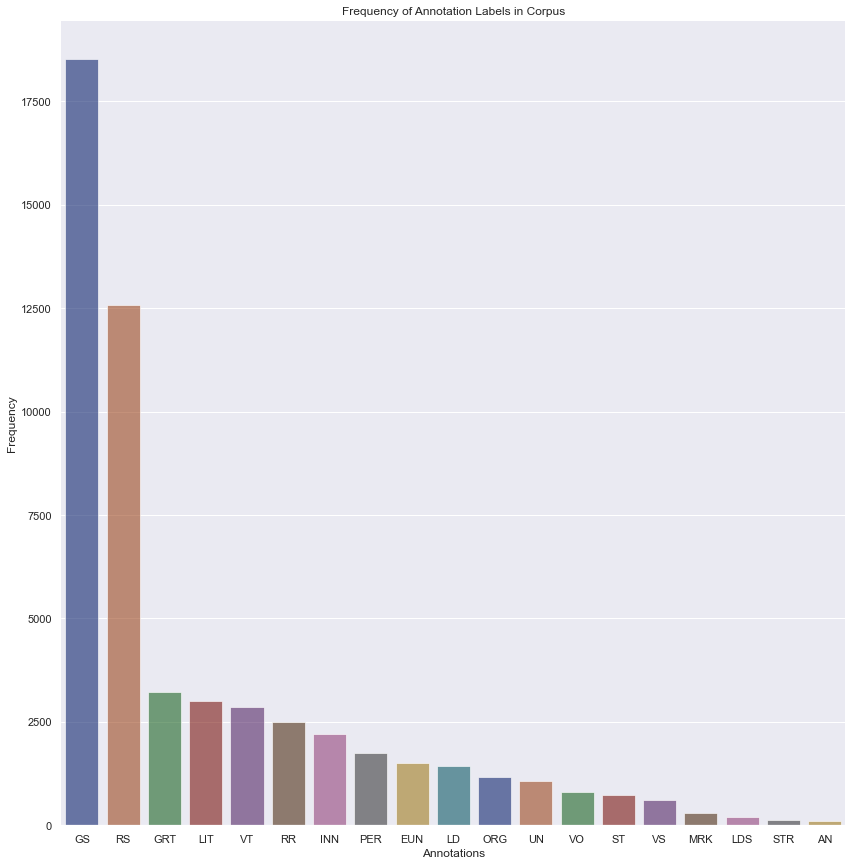

In [484]:
sns.set(style='darkgrid')
plt.rcParams["figure.figsize"] = (12,10)

g = sns.catplot(
    data=df2, kind="bar",
    x="tag", y="counts",
    ci="sd",
    palette="dark",
    height=12,
    alpha=.6
    )
g.despine(left=True)
g.set_axis_labels("Annotations", "Frequency")
g.set_xticklabels()
plt.title("Frequency of Annotation Labels in Corpus")

### 2.2 Observations on how labels are generally distributed over the dataset

How many expressions have been labelled in a text? There are about 1.8 such expressions per annotated sentence (annotations potentially comprising more than one word).

In [485]:
df3 = df1.groupby('running_text').size().reset_index(name='counts')
df3.head(20)

,running_text,counts
0,0,4
1,1,2
2,3,1
3,6,1
4,7,2
5,10,1
6,15,2
7,42,2
8,49,3
9,62,1


In [486]:
annotations_per_sentence = df3.counts.sum()/len(df3)
annotations_per_sentence.round(2)

1.8

Close to a fifth of the words in the dataset are labelled.

In [487]:
df4 = df
# register if a word is labelled (1) or not (0)
df4['label'] = df4.tag.apply(lambda x: 0 if x == 'O' else 1)
# fill a column with 1s to count words per sentence
df4['textlength'] = df.tag.apply(lambda x: 1)
labelled_words = df4.label.sum()/df4.textlength.sum()
labelled_words.round(2)

0.19

However, more than half of the texts contain no annotations.

In [488]:
df5 = df4.groupby('running_text')[['label', 'textlength']].sum().reset_index()
text_annotation_rate = len(df5[df5.label == 0])/len(df5)
text_annotation_rate

0.5446765781427972

Average word-length of a text (sentence) is 33.3

In [489]:
df_words_per_text = df5.textlength.sum()/len(df5)
words_per_text.round(2)

33.33

Generally, labels seems evenly distributed throughout the dataset, the number of labelled words being clearly correlated to the lengths of the sentence. Hence, the dataset seems consistently suitable for training a language model for NER.

<AxesSubplot:xlabel='running_text', ylabel='label'>

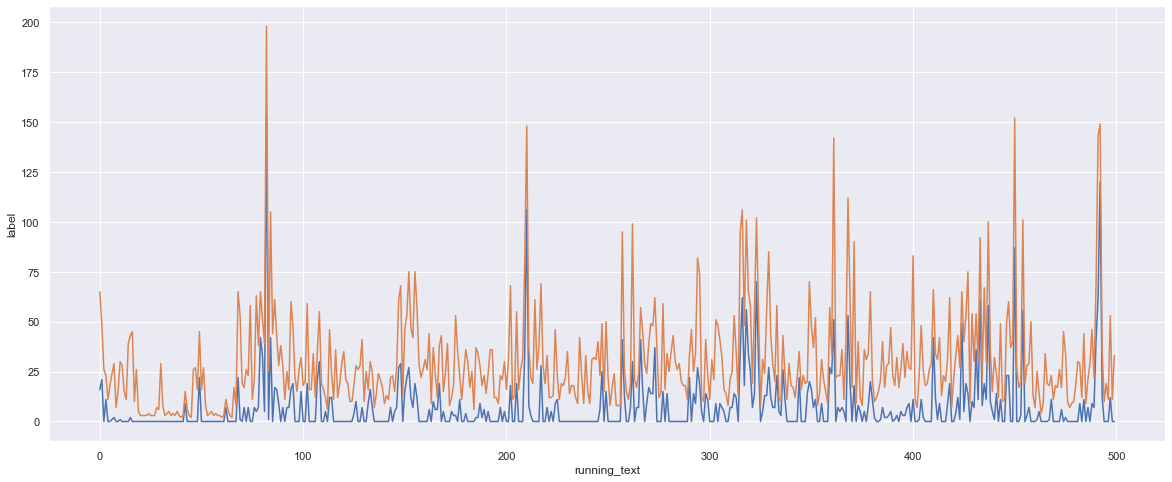

In [449]:
plt.figure(figsize = (20, 8))

plt.subplot()
sns.lineplot(x="running_text", y="label", data=df5[:500])
sns.lineplot(x="running_text", y="textlength", data=df5[:500])

## 3. Preprocessing sentences for tokenization with BERT

### 3.1 Prepare dataset for tokenization

Many of the folling steps take a guidance from https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/

In [461]:
# Generator that takes out dataframe an delivers sentences as word/tag-pairs
class GetSentence(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        word_tag_pair = lambda x: [(word, tag) for word, tag in zip(x.word.values.tolist(), x.tag.values.tolist())]
        self.grouped = self.data.groupby('running_text').apply(word_tag_pair)
        self.sentences = [sentence for sentence in self.grouped]

    def get_next(self):
        try:
            sentence = self.grouped[f"{self.n_sent}"]
            self.n_sent += 1
            return sentence
        except:
            return None


In [216]:
iterator = GetSentence(data)

In [217]:
iterator.grouped[:3]

running_text
0    [((, O), (Veräußerung, O), (von, O), (Anteilen...
1    [(), O), (1., O), (Auf, O), (der, O), (Ebene, ...
2    [(., O), (2., O), (Die, O), (rein, O), (gesell...
dtype: object

In [218]:
iterator.sentences[:3]

[[('(', 'O'),
  ('Veräußerung', 'O'),
  ('von', 'O'),
  ('Anteilen', 'O'),
  ('an', 'O'),
  ('Kapitalgesellschaften', 'O'),
  ('(', 'O'),
  ('§', 'B-GS'),
  ('17', 'I-GS'),
  ('Abs.', 'I-GS'),
  ('1', 'I-GS'),
  ('und', 'I-GS'),
  ('2', 'I-GS'),
  ('EStG', 'I-GS'),
  (')', 'O'),
  ('-', 'O'),
  ('Erwerb', 'O'),
  ('eigener', 'O'),
  ('Anteile', 'O'),
  ('durch', 'O'),
  ('die', 'O'),
  ('GmbH', 'O'),
  ('-', 'O'),
  ('Rechtslage', 'O'),
  ('nach', 'O'),
  ('BilMoG', 'B-GS'),
  ('-', 'O'),
  ('Steuerliche', 'O'),
  ('Auswirkungen', 'O'),
  ('der', 'O'),
  ('Einfügung', 'O'),
  ('des', 'O'),
  ('§', 'B-GS'),
  ('272', 'I-GS'),
  ('Abs.', 'I-GS'),
  ('1a', 'I-GS'),
  ('und', 'I-GS'),
  ('1b', 'I-GS'),
  ('HGB', 'I-GS'),
  ('durch', 'O'),
  ('das', 'O'),
  ('BilMoG', 'B-GS'),
  ('auf', 'O'),
  ('der', 'O'),
  ('Ebene', 'O'),
  ('des', 'O'),
  ('Gesellschafters', 'O'),
  ('-', 'O'),
  ('Thesaurierter', 'O'),
  ('Gewinn', 'O'),
  ('als', 'O'),
  ('preisbildender', 'O'),
  ('Bestandteil', 'O'

### 3.2 Tokenize sentences and prepare data for training

In [47]:
#tokenizer = BertTokenizer.from_pretrained('bert-base-german-cased')
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

We separate our word-tag tuples and attach the special tokens to the resulting lists.

In [219]:
# list all sentences as wordlists and append special tokens
sentences_wordlists = [[item[0] for item in sentence] for sentence in iterator.sentences]
for sentence in sentences_wordlists:
  sentence.append('[SEP]')
  sentence.insert(0, '[CLS]')

In [220]:
# list lists of tags for all sentences and append 'O' for 'no annotation'
sentences_tagslists = [[item[1] for item in sentence] for sentence in iterator.sentences]
for tagslist in sentences_tagslists:
  tagslist.append('O')
  tagslist.insert(0, 'O')

Du to limited resources, data are trained on a subset of the data. A new dataframe is shuffled before we re-extract separated lists of lists of words and tags.

In [462]:
df = pd.DataFrame({'sentence': sentences_wordlists, 'tag': sentences_tagslists})
df_shuffled = df.sample(frac=1)
df = df_shuffled.reset_index(drop=True)[:8000]
train_sentences = df.sentence.values.tolist()
train_labels = df.tag.values.tolist()

Tokenization by BERT creates subwords from unfamiliar words. These subwords should receive the same tag.

In [463]:
def bert_tokenize(sentence, wordtags):
  '''
  Function to apply the tokenizer to the words in our sentences.
  It multiplies the word-tags by the subword length to receive matching labels for all subwords that
  result from tokenization
  returns two lists: a list of lists of tokenized sentences and a list of lists of mapping labels
  '''
  
  tokenized_sentences = []
  tags = []
  for word, tag in zip(sentence, wordtags):
    # apply tokenized to words
    tokenized_word = tokenizer.tokenize(word)
    n_subwords = len(tokenized_word)
    tokenized_sentences.extend(tokenized_word)
    # multiply tag by length of subwordlist
    tags.extend([tag]*n_subwords)

  return tokenized_sentences, tags

In [225]:
sentence_tags_pairs_tokenized = [bert_tokenize(words,tags) for words,tags in zip(train_sentences, train_labels)]

Check tokenized sentences and labels

In [226]:
sentences_tokenized = [pair[0] for pair in sentence_tags_pairs_tokenized]
labels = [pair[1] for pair in sentence_tags_pairs_tokenized]

In [227]:
sentences_tokenized[0]

['[CLS]',
 '.',
 'Ein',
 'online',
 '-',
 'ch',
 '##at',
 '-',
 'Verfahren',
 'zur',
 'Durchführung',
 'der',
 'mündlichen',
 'Verhandlung',
 'über',
 'mehrere',
 'Wochen',
 'ergibt',
 'sich',
 'weder',
 'aus',
 'Art',
 '13',
 'UN',
 '-',
 'BR',
 '##K',
 ',',
 'der',
 'die',
 'Vertrags',
 '##staaten',
 'verpflichtet',
 ',',
 'einen',
 'gleich',
 '##berechtigten',
 'wirksamen',
 'Zugang',
 'zur',
 'Justiz',
 'zu',
 'gewährleisten',
 'noch',
 'aus',
 'den',
 'o',
 '##g',
 'Verfahrens',
 '##vorschriften',
 '.',
 '[SEP]']

In [228]:
labels[0]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-EUN',
 'I-EUN',
 'I-EUN',
 'I-EUN',
 'I-EUN',
 'I-EUN',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

### 3.3 Input ids, padding and attention masks

To get our data in shape as inputs to a BERT model, we need to pad our data and build attention masks.

In [464]:
# list the unique tags from the tag-column
tag_values = list(set(data['tag'].values))
tag_values.append('PAD')
# create dictionary for tags and their index values in tag_values
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [230]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(sentence) for sentence in sentences_tokenized],
                          maxlen=MAX_LEN,
                          dtype='long',
                          value=0.0,
                          truncating="post",
                          padding="post")

'[CLS]' and '[SEP]' get included as 3 and 4

In [231]:
input_ids[0]

array([    3, 26914,   198, 15141, 26935,  1985,    43, 26935,  2259,
         252,  6087,    21,  5350,  4097,   204,  2071,  2124,  3061,
         144,  3175,   147,   750,   857,  5931, 26935, 11869, 26932,
       26918,    21,    30,  4864,  4664,  3983, 26918,   303,   911,
        9927, 22279,  5963,   252,  5671,    81, 13146,   357,   147,
          86,   170, 26908,  3040,  8579, 26914,     4,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0])

In [232]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN,
                     value=tag2idx["PAD"],
                     padding="post",
                     dtype="long",
                     truncating="post")

In [233]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]
attention_masks = np.array(attention_masks)

### 3.4 Train-test-splits, tensor datasets, data loaders

In [234]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=0,
                                                            test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=0,
                                             test_size=0.1)


In [235]:
# transform train data from arrays to tensors
tr_inputs = torch.tensor(tr_inputs)
tr_tags = torch.tensor(tr_tags)
tr_masks = torch.tensor(tr_masks)

# transform validation data from arrays to tensors
val_inputs = torch.tensor(val_inputs)
val_tags = torch.tensor(val_tags)
val_masks = torch.tensor(val_masks)

In [236]:
# create tensor dataset, data loader and sequential sampler objects

train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

## 4. Define and train model

### 4.1 Choose model and set training parameters

In [ ]:
MODEL_NAME = 'bert-base-german-cased'
#tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
model = BertForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False)

In [465]:
# parameters
MAX_LEN = 75
BATCH_SIZE = 32

In [238]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
#torch.cuda.get_device_name(0)
# pass model parameters to GPU
#model.cuda();

In [240]:
# specify paramaters the optimizer should update

FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
        ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

In [478]:
EPOCHS = 3
MAX_GRAD_NORM = 1.0

# Total number of training steps is number of batches * number of epochs
total_steps = len(train_dataloader) * EPOCHS

# Choose optimizer
optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
    )

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
    )

### 4.2 Train model

In [242]:
# Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(EPOCHS, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=MAX_GRAD_NORM)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}\n".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [[tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]]
    valid_tags = [[tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]]
    
    print('Validation accuracy:\t{:.5f}'.format(accuracy_score(pred_tags, valid_tags)))
    print('Validation precision:\t{:.5f}'.format(precision_score(pred_tags, valid_tags)))
    print('Validation recall:\t{:.5f}'.format(recall_score(pred_tags, valid_tags)))
    print('Validation f1-score:\t{:.5f}'.format(f1_score(pred_tags, valid_tags)))

    print()

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.23019281814081802



Epoch:  33%|███▎      | 1/3 [51:00<1:42:01, 3060.89s/it]

Validation loss: 0.08455220215022564
Validation accuracy:	0.97692
Validation precision:	0.61279
Validation recall:	0.70361
Validation f1-score:	0.65507

Average train loss: 0.04758407977720102



Epoch:  67%|██████▋   | 2/3 [1:43:47<52:03, 3123.28s/it]

Validation loss: 0.061358662713319065
Validation accuracy:	0.98352
Validation precision:	0.75982
Validation recall:	0.72484
Validation f1-score:	0.74192

Average train loss: 0.02255226449109614



Epoch: 100%|██████████| 3/3 [4:17:31<00:00, 5150.63s/it]

Validation loss: 0.06048117569182068
Validation accuracy:	0.98651
Validation precision:	0.80808
Validation recall:	0.77922
Validation f1-score:	0.79339



Save the model for later use in the app.

In [399]:
torch.save(model.state_dict(), 'LegalBERTmodel')

### 4.3 Loss, classification report

Print a loss curve based on the training and validation losses of each epoch.

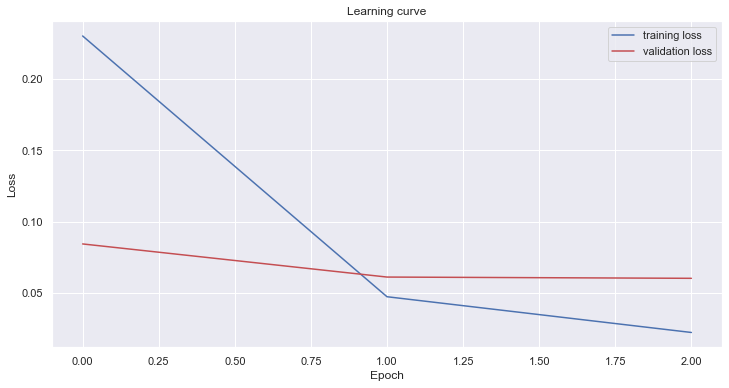

In [407]:
sns.set(style='darkgrid')

plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b', label="training loss" )
plt.plot(validation_loss_values, 'r', label="validation loss")

plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

Precision, recall and f1-score for categories ('AN' missing, because due to class size, the model was not able to deliver any values for that class)

In [305]:
from seqeval.metrics import classification_report as crs
print(crs(valid_tags, pred_tags))

              precision    recall  f1-score   support

         EUN       0.79      0.82      0.81        51
         GRT       0.86      0.74      0.79        42
          GS       0.92      0.92      0.92       296
         INN       0.74      0.64      0.68        39
          LD       0.46      0.67      0.55        18
         LDS       0.00      0.00      0.00         1
         LIT       0.70      0.78      0.74        80
         MRK       1.00      0.36      0.53        11
         ORG       0.44      0.51      0.47        41
         PER       0.83      0.91      0.87        11
          RR       0.91      0.94      0.92        32
          RS       0.83      0.90      0.86       150
          ST       0.57      1.00      0.72        13
         STR       0.00      0.00      0.00         2
          UN       0.38      0.53      0.44        19
          VO       0.46      0.50      0.48        12
          VS       0.09      0.06      0.07        17
          VT       0.79    

/opt/homebrew/Caskroom/miniforge/base/envs/.venv/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 5. Comparison to results from Leitner, Rehm & Moreno-Schneider*

The above model performs consistenly weaker in all measures compared to the CRF-F, CRF-FG and CRF-FGL as well as the BiLSTM-CRF BiLSTM-CRF+ and BiLSTM-CNN-CRF models trained by these authors.

At the same time, they cannot be directly compared. The BERT model was trained and validated based only on a fraction of the data (on 8000 as opposed to the full dataset of 66723 sentences) due to computational resources. Looking at the performance of BERT-models in NER, working with the full dataset could be expected to beat the benchmark from 2019.

Training the model to predict the coarse-grained labels might have given a better result.

*Leitner E., Rehm G., Moreno-Schneider J. (2019) Fine-Grained Named Entity Recognition in Legal Documents. In: Acosta M., Cudré-Mauroux P., Maleshkova M., Pellegrini T., Sack H., Sure-Vetter Y. (eds) Semantic Systems. The Power of AI and Knowledge Graphs. SEMANTiCS 2019. Lecture Notes in Computer Science, vol 11702. Springer, Cham. https://doi.org/10.1007/978-3-030-33220-4_20

## 6. Function to label new sentences

This function tests new sentences. It shall be used in a demonstrator app in which user can have the model label sample sentence tokens.

In [479]:
def test_sentence(sentence):

    '''
    function to tokenize, encode an input sentence and predict labels
    return df with the input and predicted labels
    '''
    
    new_tokens, new_labels = [], []

    tokenized_sentence = tokenizer.encode(sentence)
    input_ids = torch.tensor([tokenized_sentence])

    with torch.no_grad():
        output = model(input_ids)
    label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

    tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])

    for token, label_idx in zip(tokens, label_indices[0]):
        if token.startswith("##"):
            new_tokens[-1] = new_tokens[-1] + token[2:]
        else:
            new_labels.append(tag_values[label_idx])
            new_tokens.append(token)
    for token, label in zip(new_tokens, new_labels):
        df = pd.DataFrame({'Sentence': new_tokens, 'Label': new_labels})
    
    return df#.transpose()

In [474]:
test_sentence("Die Taten sind nach Art, Umständen und Beweggründen auch nicht als jugendtypische Verfehlungen iSd § 105 Abs. 1 Nr. 2 JGG zu sehen. Vielmehr handelt es sich um kriminelle Verhaltensweisen, die gerade bei Drogenkonsumenten in allen Altersschichten anzutreffen sind.")

,Sentence,Label
0,[CLS],O
1,Die,O
2,Taten,O
3,sind,O
4,nach,O
5,Art,O
6,",",O
7,Umständen,O
8,und,O
9,Beweggründen,O


### Resources

Leitner, E., Rehm, G., and Moreno-Schneider, J. (2019).Fine-grained Named Entity Recognition in legal documents.

Leitner, E., Rehm, G., and Moreno-Schneider, J. (2020). A Dataset of German Legal Documents for Named Entity Recognition

https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/